# Neural Network
We will try two ways of modelling a Neural Network with 3 layers. We will use dropout in between each layer for one architecture and leave out the dropout layers in the other architecture.

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split

In [2]:

df = pd.read_csv('clean_sport.csv', 
                  parse_dates=['First_Seen','Last_Seen','Last_Modified'], 
                  dtype={'Postcode': 'category'},
                  dayfirst=True)
#sport = df[df['Body'] == 'Super Sport'].reset_index(drop=True)
#sport.drop(['Description'],axis=1,inplace=True)
df.head()

,Bore,Compression_Ratio,Cylinders,Engine_Stroke,Engine_Voltage,Front_Brake_Diameter,Front_Suspension_Travel,Fuel_Tank_Capacity,Gear_Number,Ground_Clearance,...,Starter,State,Suburb,Swingarm_Type,Traction_Control,URL,Wheel_Type,Seller,Brand,Sold
0,97.000,11.0,2.0,4.0,12.0,320.00000,120.0,20.0,6.0,137.338051,...,Electric,QLD,Mudgeeraba,Dual_Sided,No,https://www.bikesales.com.au/bikes/details/200...,Spoke,Private,Aprilia,For Sale
1,79.685,12.0,2.0,4.0,12.0,309.35404,120.0,17.7,6.0,137.338051,...,Electric,VIC,Kinglake,Dual_Sided,No,https://www.bikesales.com.au/bikes/details/200...,Spoke,Private,Aprilia,For Sale
2,79.685,12.0,2.0,4.0,12.0,309.35404,120.0,17.7,6.0,137.338051,...,Electric,NSW,Lavender_bay,Dual_Sided,No,https://www.bikesales.com.au/bikes/details/200...,Spoke,Private,Aprilia,For Sale
3,97.000,12.0,2.0,4.0,12.0,309.35404,120.0,17.7,6.0,137.338051,...,Electric,WA,Hamersley,Dual_Sided,No,https://www.bikesales.com.au/bikes/details/200...,Spoke,Private,Aprilia,For Sale
4,97.000,12.0,2.0,4.0,12.0,309.35404,120.0,17.7,6.0,137.338051,...,Electric,NSW,Illawong,Dual_Sided,No,https://www.bikesales.com.au/bikes/details/200...,Spoke,Private,Aprilia,For Sale


In [3]:
def r_squared(y, y_pred):
    res = y - y_pred
    tot = y - y.mean()

    r2 = 1 - res.dot(res) / tot.dot(tot)
    return r2

In [4]:
def dealer_split_data(df,features):
        
    train = df[df['Seller_Dealer'] == 1]
    test = df[df['Seller_Dealer'] == 0]

    X_train, y_train = train[features], train['Price']
    X_test, y_test = test[features], test['Price']

    return X_train, y_train, X_test, y_test

In [5]:
def add_dummy_variables(df, categorical_features=None):
        
    if (categorical_features == None):
        categorical_features = df.select_dtypes(exclude='number').columns

    # ignore the URL feature when training
    categorical_features = list(set(categorical_features) - set('URL'))

    additional = pd.get_dummies(df[categorical_features])
    df[additional.columns] = additional

    df.drop(categorical_features, axis=1, inplace=True)

    return df

In [6]:
# Create a feature describing the type of deal based on the ratio 
# of predicted price to sale price.
def deal_type(df):

    df['Price_ratio'] = df['Price'] / df['Predicted_Price']

    df['Deal_type'] = 'Dont Bother'
    df['Deal_type'][df['Price_ratio'] < 0.9] = 'Negotiate'
    df['Deal_type'][df['Price_ratio'] < 0.8] = 'Good Deal'
    df['Deal_type'][df['Price_ratio'] < 0.75] = 'Great Deal'        
    df['Deal_type'][df['Price_ratio'] < 0.5] = 'Its a steal'

    return df

# diplay the predicted price and sale price using the deal type feature 
# to distinguish a good deal.
def plot_deals(df, x, y, title='', figsize=(12,10)):

    negotiate = df[df['Deal_type'] == 'Negotiate']
    good = df[df['Deal_type'] == 'Good Deal']
    great = df[df['Deal_type'] == 'Great Deal']
    steal = df[df['Deal_type'] == 'Its a steal']

    ax = plt.figure(figsize=figsize)

    sns.scatterplot(x=x,y=y,data=df,color='black',alpha=0.3);
    sns.scatterplot(x=x,y=y,data=negotiate,label='Negotiate');
    sns.scatterplot(x=x,y=y,data=good,label='Good Deal');
    sns.scatterplot(x=x,y=y,data=great,label='Great Deal');
    sns.scatterplot(x=x,y=y,data=steal,label='Its a steal');
    ax = sns.lineplot(x=[df[x].min(),df[x].max()], y=[df[x].min(),df[x].max()],
                      linewidth=1, alpha=0.5, color='red')
    ax.lines[0].set_linestyle("--")
    
    
    plt.title(title,fontsize=24)
    plt.xlabel(x, fontsize=18)
    plt.ylabel(y, fontsize=18)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    return None


## Convert categorical variables to numerical.

In [7]:
df = add_dummy_variables(df)


In [8]:

features = list(set(df.columns) - set(['Price']))

# Ignore the URL features
update_features = []
for feature in features:
    if 'URL' not in feature:
        update_features.append(feature)
features = update_features


## Split the data using the Dealer data.

In [9]:
dealer_X, dealer_y, private_X, private_y = dealer_split_data(df, features)
        

In [10]:
X_train, X_test, y_train, y_test = train_test_split(dealer_X, dealer_y, random_state=1, test_size=0.3)

# Set up the Neural Networks

## Neural Network with Dropout

In [11]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils import to_categorical

Using TensorFlow backend.


In [12]:
def neural_network_dropout(X_train, y_train, train=True):
    
    node = 100
    n_cols = X_train.shape[1]

    if train:
        X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, random_state=1, test_size=0.3)
        n_cols = X_train.shape[1]
    
    
    model = Sequential()

    model.add(Dense(n_cols, activation = 'relu', input_shape = (n_cols, )))
    
    model.add(Dense(node, activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(node, activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(node, activation = 'relu'))

    # Add the output layer
    model.add(Dense(1, activation = 'linear'))
    
    model.compile(optimizer = 'adam', loss = 'mse', metrics = ['mse'])
    
    model.fit(X_train, y_train, validation_split = 0.25, batch_size = 20, epochs = 1000, verbose = 0)

    if train:
        score = model.evaluate(X_test, y_test)
        print (f'Testing score: {score}')
    
    return model

In [13]:
# Train the neural network
model = neural_network_dropout(X_train, y_train, train=True)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
194/194 [==============================] - 0s 443us/step
Testing score: [26311547.958762888, 26311547.958762888]


In [14]:
# Fit the full Neural Network
model = neural_network_dropout(dealer_X, dealer_y, train=False)


In [15]:
# Make predictions
df['Predicted_Price'] = model.predict(df[features])


In [16]:
# Calculate the R squared score from the full model
dealer_df = df[df['Seller_Dealer'] == 1]

nueral_network_dropout_r2 = r_squared(dealer_df['Price'], dealer_df['Predicted_Price'])
nueral_network_dropout_r2

0.5739767544471152

### Visualise the predictions

In [17]:
df = deal_type(df)

C:\Users\Beau\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Beau\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\Beau\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Beau\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: Se

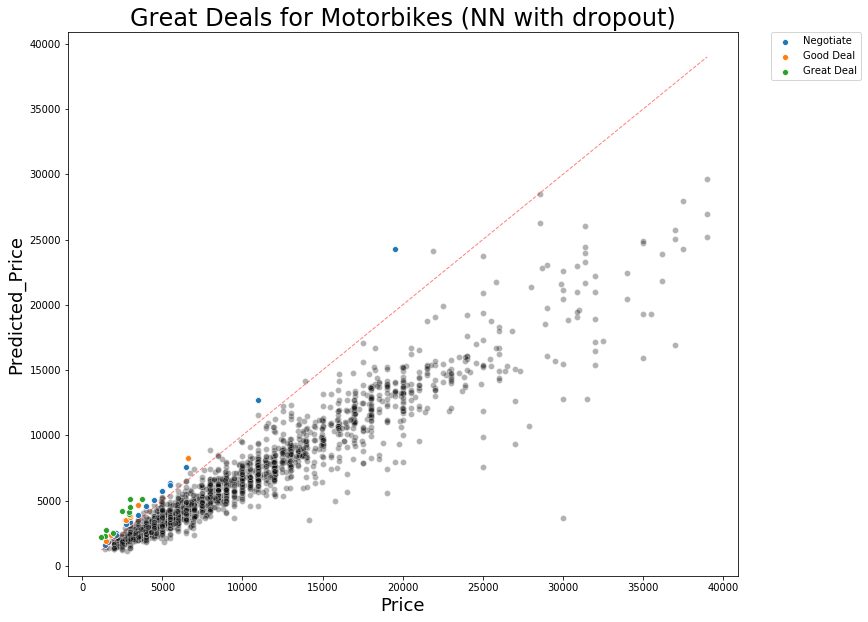

In [18]:
plot_deals(df, 'Price', 'Predicted_Price',title='Great Deals for Motorbikes (NN with dropout)')

## Neural Network without dropout

In [19]:
df = pd.read_csv('clean_sport.csv', 
                  parse_dates=['First_Seen','Last_Seen','Last_Modified'], 
                  dtype={'Postcode': 'category'},
                  dayfirst=True)
#sport = df[df['Body'] == 'Super Sport'].reset_index(drop=True)
#sport.drop(['Description'],axis=1,inplace=True)
df.head()


,Bore,Compression_Ratio,Cylinders,Engine_Stroke,Engine_Voltage,Front_Brake_Diameter,Front_Suspension_Travel,Fuel_Tank_Capacity,Gear_Number,Ground_Clearance,...,Starter,State,Suburb,Swingarm_Type,Traction_Control,URL,Wheel_Type,Seller,Brand,Sold
0,97.000,11.0,2.0,4.0,12.0,320.00000,120.0,20.0,6.0,137.338051,...,Electric,QLD,Mudgeeraba,Dual_Sided,No,https://www.bikesales.com.au/bikes/details/200...,Spoke,Private,Aprilia,For Sale
1,79.685,12.0,2.0,4.0,12.0,309.35404,120.0,17.7,6.0,137.338051,...,Electric,VIC,Kinglake,Dual_Sided,No,https://www.bikesales.com.au/bikes/details/200...,Spoke,Private,Aprilia,For Sale
2,79.685,12.0,2.0,4.0,12.0,309.35404,120.0,17.7,6.0,137.338051,...,Electric,NSW,Lavender_bay,Dual_Sided,No,https://www.bikesales.com.au/bikes/details/200...,Spoke,Private,Aprilia,For Sale
3,97.000,12.0,2.0,4.0,12.0,309.35404,120.0,17.7,6.0,137.338051,...,Electric,WA,Hamersley,Dual_Sided,No,https://www.bikesales.com.au/bikes/details/200...,Spoke,Private,Aprilia,For Sale
4,97.000,12.0,2.0,4.0,12.0,309.35404,120.0,17.7,6.0,137.338051,...,Electric,NSW,Illawong,Dual_Sided,No,https://www.bikesales.com.au/bikes/details/200...,Spoke,Private,Aprilia,For Sale


In [20]:
df = add_dummy_variables(df)


In [21]:
features = list(set(df.columns) - set(['Price']))

# Ignore the URL features
update_features = []
for feature in features:
    if 'URL' not in feature:
        update_features.append(feature)
features = update_features


In [22]:
dealer_X, dealer_y, private_X, private_y = dealer_split_data(df, features)


In [23]:
X_train, X_test, y_train, y_test = train_test_split(dealer_X, dealer_y, random_state=1, test_size=0.3)


In [24]:
def neural_network(X_train, y_train, train=True):
    
    node = 100
    n_cols = X_train.shape[1]

    if train:
        X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, random_state=1, test_size=0.3)
        n_cols = X_train.shape[1]
    
    model = Sequential()

    model.add(Dense(n_cols, activation = 'relu', input_shape = (n_cols, )))
    
    model.add(Dense(node, activation = 'relu'))
    model.add(Dense(node, activation = 'relu'))
    model.add(Dense(node, activation = 'relu'))
    
    # Add the output layer
    model.add(Dense(1, activation = 'linear'))
    
    model.compile(optimizer = 'adam', loss = 'mse', metrics = ['mse'])
    
    model.fit(X_train, y_train, validation_split = 0.25, batch_size = 20, epochs = 1000, verbose = 0)

    if train:
        score = model.evaluate(X_test, y_test)
        print (f'Testing score: {score}')
    
    return model

In [25]:
# Train the neural network
model = neural_network(X_train, y_train, train=True)


194/194 [==============================] - 0s 319us/step
Testing score: [6783159.195876288, 6783159.195876288]


In [26]:
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 1850)              3424350   
_________________________________________________________________
dense_12 (Dense)             (None, 100)               185100    
_________________________________________________________________
dense_13 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_14 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 101       
Total params: 3,629,751
Trainable params: 3,629,751
Non-trainable params: 0
_________________________________________________________________
None


In [27]:
# Fit the full Neural Network
model = neural_network(dealer_X, dealer_y, train=False)


In [28]:
# Make predictions
df['Predicted_Price'] = model.predict(df[features])

# dealer_predictions = model.predict(dealer_X)
# private_predictions = model.predict(private_X)


In [29]:
dealer_df = df[df['Seller_Dealer'] == 1]

nueral_network_r2 = r_squared(dealer_df['Price'], dealer_df['Predicted_Price'])
nueral_network_r2

0.9566408408868395

In [30]:
df = deal_type(df)

C:\Users\Beau\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Beau\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\Beau\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Beau\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: Se

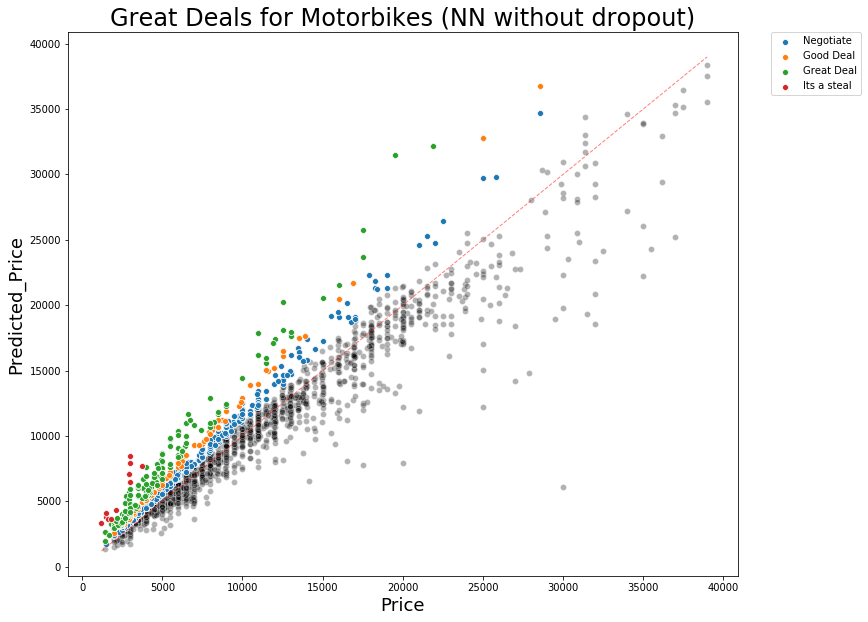

In [31]:


plot_deals(df, 'Price', 'Predicted_Price',title='Great Deals for Motorbikes (NN without dropout)')

In [32]:
# Identify the best deal
# Price: ~ $7,000
# Predicted Proce: ~ $15,000
value = df[df['Deal_type'] == 'Its a steal']['Price'].max()
test = df[(df['Deal_type'] == 'Its a steal') & (df['Price'] == value)]
test

,Bore,Compression_Ratio,Cylinders,Engine_Stroke,Engine_Voltage,Front_Brake_Diameter,Front_Suspension_Travel,Fuel_Tank_Capacity,Gear_Number,Ground_Clearance,...,Brand_Triumph,Brand_Yamaha,Side_Stand_No,Side_Stand_Standard,Side_Stand_Yes,Swingarm_Type_Dual_Sided,Swingarm_Type_Single_Sided,Predicted_Price,Price_ratio,Deal_type
159,75.0,12.0,4.0,4.0,12.0,310.0,109.0,18.0,6.0,130.0,...,0,0,0,1,0,1,0,7733.337891,0.484914,Its a steal


In [33]:
# Find the 'its a steal' bike in the original dataframe
original_df = pd.read_csv('clean_sport.csv', 
                          parse_dates=['First_Seen','Last_Seen','Last_Modified'], 
                          dtype={'Postcode': 'category'},
                          dayfirst=True)

In [34]:
original_df.select_dtypes(include='number').columns


Index(['Bore', 'Compression_Ratio', 'Cylinders', 'Engine_Stroke',
       'Engine_Voltage', 'Front_Brake_Diameter', 'Front_Suspension_Travel',
       'Fuel_Tank_Capacity', 'Gear_Number', 'Ground_Clearance', 'Height',
       'Kilometers', 'Length', 'Maximum_Power', 'Maximum_Power_RPM', 'Price',
       'Rake_(Caster_Angle)', 'Rear_Brake_Diameter', 'Rear_Suspension_Travel',
       'Recommended_RON', 'Seating_Capacity', 'Stroke', 'Throttle_Bore',
       'Trail', 'Valves_Per_Cylinder', 'Wet_Operational_Weight', 'Wheelbase',
       'Width', 'Remaining_Warranty', 'Remaining_Registration', 'Age',
       'Live_Add', 'Engine_Size'],
      dtype='object')

In [35]:
# Get the URL
original_df[(original_df['Bore'] == test['Bore'].values[0]) & 
            (original_df['Compression_Ratio'] == test['Compression_Ratio'].values[0]) &
            (original_df['Cylinders'] == test['Cylinders'].values[0]) & 
            (original_df['Front_Brake_Diameter'] == test['Front_Brake_Diameter'].values[0]) &
            (original_df['Front_Suspension_Travel'] == test['Front_Suspension_Travel'].values[0]) & 
            (original_df['Fuel_Tank_Capacity'] == test['Fuel_Tank_Capacity'].values[0]) & 
            (original_df['Ground_Clearance'] == test['Ground_Clearance'].values[0]) & 
            (original_df['Height'] == test['Height'].values[0]) & 
            (original_df['Kilometers'] == test['Kilometers'].values[0]) & 
            (original_df['Length'] == test['Length'].values[0]) & 
            (original_df['Maximum_Power_RPM'] == test['Maximum_Power_RPM'].values[0]) & 
            (original_df['Price'] == test['Price'].values[0])]['URL'].values
            


array(['https://www.bikesales.com.au/bikes/details/2006-honda-cbr1000rr-fireblade/SSE-AD-3964798/?Cr=0'],
      dtype=object)

In [36]:
test['Predicted_Price']

159    7733.337891
Name: Predicted_Price, dtype: float32

In [37]:
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 1850)              3424350   
_________________________________________________________________
dense_17 (Dense)             (None, 100)               185100    
_________________________________________________________________
dense_18 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_19 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 101       
Total params: 3,629,751
Trainable params: 3,629,751
Non-trainable params: 0
_________________________________________________________________
None
